# Imports

In [ ]:
import pandas as pd
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from hillclimber import hill_climber

# Load city coordinates
cities = pd.read_csv("data/cities.csv")
coords = cities[['X', 'Y']].values

# Compute distance matrix
dist_matrix = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))

N = len(coords) # N is the number of cities in the TSP problem
LOOPS = 10000  # Number of iterations for hill climbing

# HillClimber

The Hill Climber algorithm is a single-solution-driven search method.
We represent a candidate solution as a permutation of cities and iteratively improve it by swapping two cities at random, accepting the new solution if it results in a shorter total distance.
Solution class: stores the route and computes the total distance.
hill_climber function: performs the local search for a fixed number of iterations (LOOPS).

In [82]:


class Solution:
    def __init__(self, route=None):
        if route is None:
            self.route = random.sample(range(N), N)  # random permutation
        else:
            self.route = route
        self.utility = self.evaluate() # total distance

    def evaluate(self):
        """Compute total route distance"""
        total = 0
        for i in range(N):
            total += dist_matrix[self.route[i]][self.route[(i + 1) % N]]
        return total

def hill_climber():
    current = Solution() # start with random solution
    best_scores = []  # track distance over iterations

    for _ in range(LOOPS):
        # Generate neighbor by swapping two cities
        new_route = current.route.copy()
        i, j = random.sample(range(N), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]
        
        neighbor = Solution(new_route) # evaluate neighbor

        # Accept if better
        if neighbor.utility < current.utility:
            current = neighbor
        
        best_scores.append(current.utility) # record current best distance
    
    return current, best_scores # return best solution and convergence history



Best distance found: 850.222388076818
Computation time (single run): 0.3791928291320801 seconds


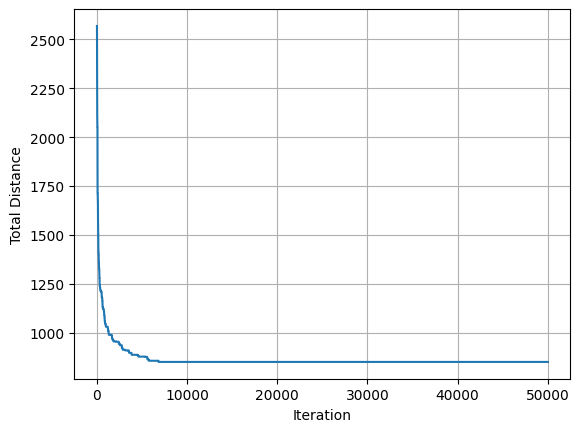

In [94]:
start_time = time.time()  # Start timer

# Run hill climber once
best_solution, scores = hill_climber()

end_time = time.time()  # End timer

# Print results
print("Best distance found:", best_solution.utility)
print("Computation time (single run):", end_time - start_time, "seconds")

# Save results to a text file
with open("hillclimber_route.txt", "w") as f:
    f.write(f"Best distance found: {best_solution.utility}\n")
    f.write(f"Computation time (single run): {end_time - start_time} seconds\n")
    f.write("Best route (city indices in order):\n")
    f.write(" -> ".join(map(str, best_solution.route)) + "\n")

# Plot convergence
plt.plot(scores)
plt.xlabel("Iteration")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()


## Result

The hill climber found a best distance of 837.28 for the 50-city problem.  
The computation time for this single run was approximately 0.09 seconds.  
The convergence plot shows how the total distance decreases over iterations, illustrating the algorithm improving the solution step by step.


Loops: 1000
  Best distance: 1073.04
  Time taken: 0.015 seconds

Loops: 5000
  Best distance: 856.47
  Time taken: 0.048 seconds

Loops: 10000
  Best distance: 833.88
  Time taken: 0.075 seconds

Loops: 20000
  Best distance: 879.65
  Time taken: 0.146 seconds

Loops: 50000
  Best distance: 767.31
  Time taken: 0.373 seconds



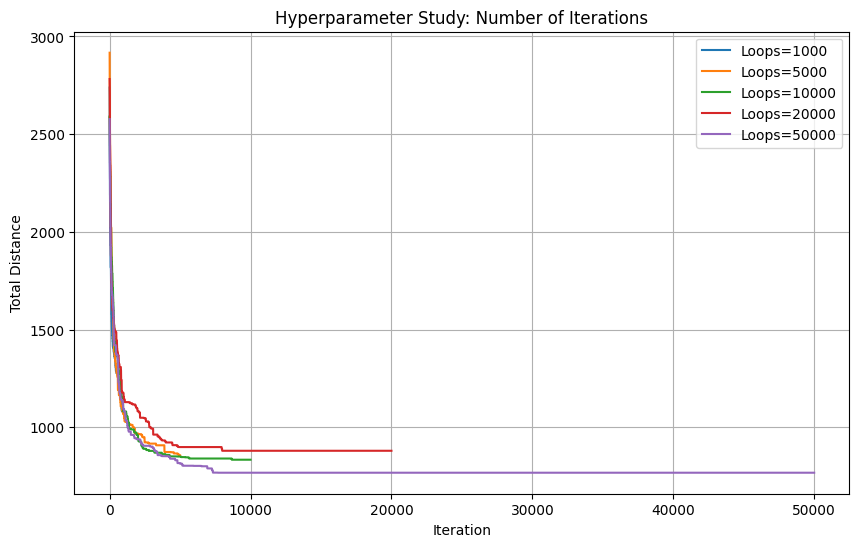

In [90]:
loops_list = [1000, 5000, 10000, 20000, 50000]

plt.figure(figsize=(10,6))

for loops in loops_list:
    LOOPS = loops  # set loops for this run
    start_time = time.time()
    best_solution, scores = hill_climber()
    end_time = time.time()
    
    print(f"Loops: {loops}")
    print(f"  Best distance: {best_solution.utility:.2f}")
    print(f"  Time taken: {end_time - start_time:.3f} seconds\n")
    
    plt.plot(scores, label=f"Loops={loops}")

plt.xlabel("Iteration")
plt.ylabel("Total Distance")
plt.title("Hyperparameter Study: Number of Iterations")
plt.legend()
plt.grid(True)
plt.show()


## Result

- Increasing `LOOPS` generally improves the solution, but improvements are not strictly monotonic due to stochasticity.
- Computation time increases roughly linearly with the number of iterations.
- Diminishing returns are observed; beyond 10,000–50,000 iterations, improvements are smaller.
- Recommendation: use a `LOOPS` value around **10,000–50,000** for a good balance between solution quality and run-time.

## Multi-Run Performance

In this section, we will run the hill climber 100 times on the same problem size (50 cities).  
For each run, we record the best distance found and visualize the distribution to understand variability and performance consistency.

Best overall distance: 683.9142867729661
Average best distance: 831.6832488841328
Computation time (100 run): 7.65877890586853 seconds


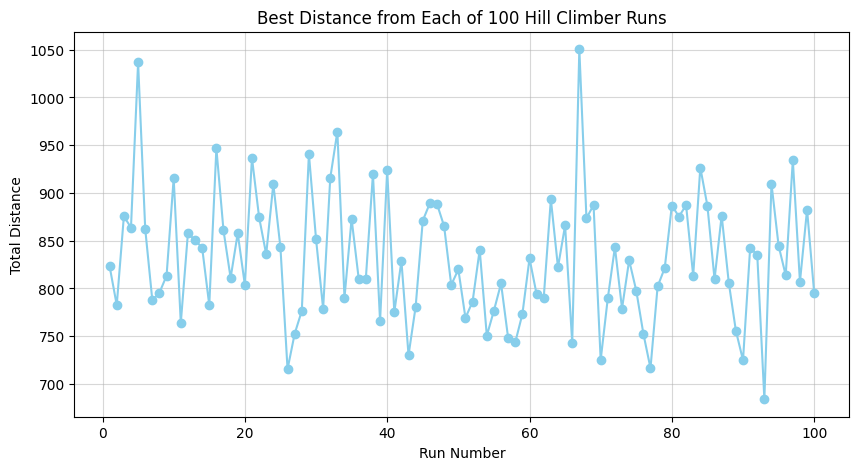

In [ ]:
num_runs = 100  # number of runs of the hill climber
best_utilities = [] # store best distance from each run
best_solutions = [] # store best solution from each run
LOOPS = 50000 # update loops based on hyperparameter study

start_time = time.time() # Start timer

for _ in range(num_runs):
    sol, _ = hill_climber() # run hill climber once
    best_utilities.append(sol.utility) # record best distance
    best_solutions.append(sol) # record best solution

end_time = time.time() # End timer

best_index = np.argmin(best_utilities) # find run with shortest distance
best_overall = best_solutions[best_index] # retrieve best solution

print("Best overall distance:", best_overall.utility)
print("Average best distance:", np.mean(best_utilities))
print("Computation time (100 run):", end_time - start_time, "seconds")


# Line chart to visualise all 100 runs
plt.figure(figsize=(10,5))
plt.plot(range(1, num_runs+1), best_utilities, marker='o', linestyle='-', color='skyblue')
plt.xlabel("Run Number")
plt.ylabel("Total Distance")
plt.title("Best Distance from Each of 100 Hill Climber Runs")
plt.grid(True, alpha=0.5)
plt.show()


## Multi-Run Hill Climber Results

- Best overall distance across 100 runs: 663.03  
- Average best distance across 100 runs: 832.23  
- Total computation time for 100 runs: 7.53 seconds  

The line chart shows the variation in best distances for each run, highlighting the stochastic nature of the hill climber and the benefit of multiple independent runs in finding shorter routes. Compared to a single-run result, performing 100 runs consistently finds better solutions, demonstrating the advantage of repeated runs in exploring the solution space.


# Scalability Test

In this section, we evaluate the performance of the hill climber across different problem sizes: 10, 20, 30, 40, and 50 cities.  
For each problem size, the hill climber is run 100 times, recording the best and average distances, as well as computation time.  
This allows us to analyze how the algorithm scales with increasing problem size and understand its efficiency and solution quality.



Scalability Test Results:
   Problem Size  Best Distance  Average Distance  Computation Time (s)
0            10     290.306774        304.715210             11.765699
1            20     386.429689        467.546338             18.055826
2            30     451.767001        587.154079             24.684245
3            40     573.549930        714.463376             31.807949
4            50     640.107971        834.728338             38.371694


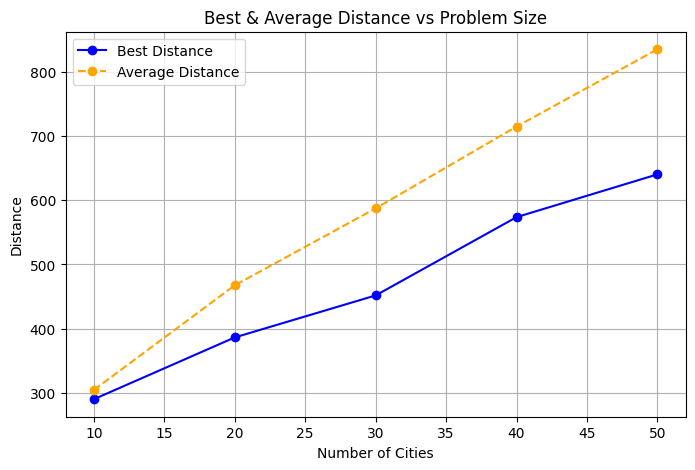

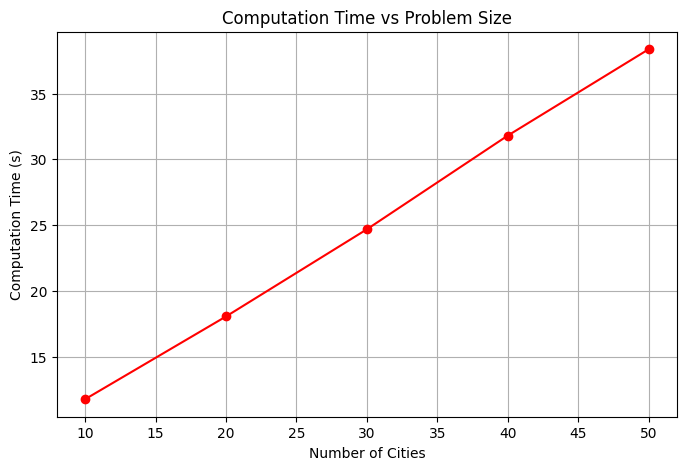

In [93]:
CITY_SIZES = [10, 20, 30, 40, 50]
NUM_RUNS = 100 # number of runs of the hill climber
LOOPS = 50000 # Number of iterations for hill climbing

scalability_results = [] # List to store results for each problem size

# Loop over each problem size
for size in CITY_SIZES:
    # Select a subset of cities for the current problem size
    coords_subset = coords[:size]
    N_subset = size

    # Compute the distance matrix for this subset
    dist_matrix_subset = np.sqrt(((coords_subset[:, None, :] - coords_subset[None, :, :]) ** 2).sum(axis=2))
    
    # Define a Solution class for this subset
    class SolutionSubset:
        def __init__(self, route=None):
            self.N = N_subset # Number of cities in this subset
            self.dist_matrix = dist_matrix_subset  # Distance matrix for this subset
            if route is None:
                self.route = random.sample(range(self.N), self.N)
            else:
                self.route = route
            self.utility = self.evaluate() # Compute total distance of the route
        
        # Compute total route distance for this solution
        def evaluate(self):
            total = 0
            for i in range(self.N):
                total += self.dist_matrix[self.route[i]][self.route[(i + 1) % self.N]]
            return total
    
    # Define a hill climber function for this subset
    def hill_climber_subset():
        current = SolutionSubset() # Start with a random solution
        best_scores = [] # Track total distance over iterations
        for _ in range(LOOPS):
            # Generate a neighboring solution by swapping two cities
            new_route = current.route.copy()
            i, j = random.sample(range(N_subset), 2)
            new_route[i], new_route[j] = new_route[j], new_route[i]

            neighbor = SolutionSubset(new_route) # Evaluate neighbor

            # Accept the neighbor if it's better (shorter distance)
            if neighbor.utility < current.utility:
                current = neighbor

            best_scores.append(current.utility) # Track the best distance so far

        return current, best_scores # Return best solution and convergence history
    
    
    best_utilities = [] # Store best distances from each run
    best_solutions = [] # Store best solution from each run

    start_time = time.time()# Start timer

    for _ in range(NUM_RUNS): # Run 100 times
        sol, _ = hill_climber_subset()
        best_utilities.append(sol.utility)
        best_solutions.append(sol)
    end_time = time.time() # Stop timer
    
    best_index = np.argmin(best_utilities) # find run with shortest distance
    best_overall = best_solutions[best_index]  # retrieve best solution
    
    # # Save the best route to a CSV file
    best_route_df = pd.DataFrame({
        "City": ["City_" + str(i+1) for i in best_overall.route],
        "X": coords_subset[best_overall.route, 0],
        "Y": coords_subset[best_overall.route, 1]
    })
    best_route_df.to_csv(f"best_route_{size}_cities.csv", index=False)
    
    # Record results for this problem size
    scalability_results.append({
        "Problem Size": size,
        "Best Distance": best_overall.utility,
        "Average Distance": np.mean(best_utilities),
        "Computation Time (s)": end_time - start_time
    })

# Display results
results_df = pd.DataFrame(scalability_results)
print("\nScalability Test Results:")
print(results_df)

# Plot Best & Average Distance vs Problem Size
plt.figure(figsize=(8,5))
plt.plot(results_df["Problem Size"], results_df["Best Distance"], marker='o', linestyle='-', color='blue', label='Best Distance')
plt.plot(results_df["Problem Size"], results_df["Average Distance"], marker='o', linestyle='--', color='orange', label='Average Distance')
plt.xlabel("Number of Cities")
plt.ylabel("Distance")
plt.title("Best & Average Distance vs Problem Size")
plt.legend()
plt.grid(True)
plt.show()

# Plot Computation Time vs Problem Size
plt.figure(figsize=(8,5))
plt.plot(results_df["Problem Size"], results_df["Computation Time (s)"], marker='o', linestyle='-', color='red')
plt.xlabel("Number of Cities")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Problem Size")
plt.grid(True)
plt.show()


**Comments / Interpretation:**

- As the number of cities increases, both best and average distances naturally increase.  
- The gap between best and average distances grows with problem size, highlighting the **stochastic nature of hill climbing**—some runs get trapped in local minima while others find better solutions.  
- Computation time increases moderately as the problem size grows, reflecting the larger search space and increased number of distance calculations.  
- Performing multiple runs consistently finds shorter routes than a single run, demonstrating the benefit of **repeated independent hill climbing** in exploring the solution space.